In [1]:
# Imports
import numpy as np

import torch
import torch.nn as nn
import torch.nn.functional as F


from sklearn.model_selection import train_test_split
from torch.utils.data import DataLoader, Subset, TensorDataset

from torchsummary import summary
import torchvision as tv
import torchvision.transforms as T
import copy

import matplotlib.pyplot as plt
import matplotlib_inline.backend_inline as backend_inline

backend_inline.set_matplotlib_formats("svg")


#### Pytorch device specific configuration ###

# Pytorch Gpu Configuration for Cuda
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# # Pytorch Gpu Configuration for directml(AMD GPU)
# import torch_directml

# device = torch_directml.device()

# Set default device
torch.set_default_device(device)

In [38]:
# transformations
transform = T.Compose([T.ToTensor(), T.Normalize([0.5, 0.5, 0.5], [0.5, 0.5, 0.5])])

# import the data and simultaneously apply the transform
trainset = tv.datasets.CIFAR10(
    root="../Datasets/", train=True, download=True, transform=transform
)
testset = tv.datasets.CIFAR10(
    root="../Datasets/", train=False, download=True, transform=transform
)
# transform to dataloaders
batchsize = 32
train_loader = DataLoader(
    trainset,
    batch_size=batchsize,
    shuffle=True,
    drop_last=True,
    generator=torch.Generator(device=device),
)
test_loader = DataLoader(
    testset, batch_size=len(testset), generator=torch.Generator(device=device)
)

Files already downloaded and verified
Files already downloaded and verified


Data shapes (train/test):
torch.Size([10000, 3, 32, 32])

Data value range:
(tensor(-1.), tensor(1.))


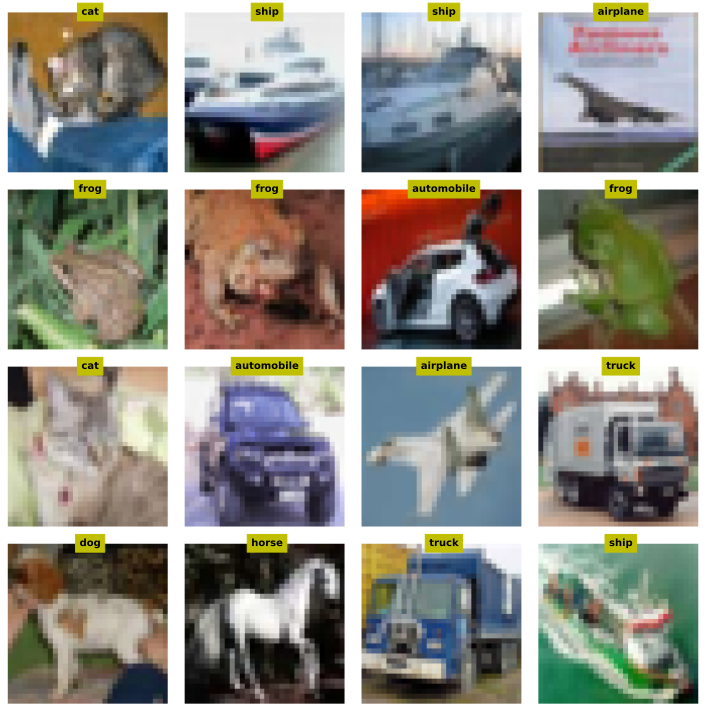

In [40]:
X, y = next(iter(test_loader))

# try again
print("Data shapes (train/test):")
print(X.data.shape)

# and the range of pixel intensity values
print("\nData value range:")
print((torch.min(X.data), torch.max(X.data)))
# inspect a few random images

fig, axs = plt.subplots(4, 4, figsize=(10, 10))

for i, ax in enumerate(axs.flatten()):

    # extract that image (need to transpose it back to 32x32x3)
    pic = X.data[i].numpy().transpose((1, 2, 0))
    pic = pic / 2 + 0.5  # undo normalization

    # and its label
    label = trainset.classes[y[i]]

    # and show!
    ax.imshow(pic)
    ax.text(
        16, 0, label, ha="center", fontweight="bold", color="k", backgroundcolor="y"
    )
    ax.axis("off")

plt.tight_layout()
plt.show()

In [41]:
# Create a function to create a model
# Basic knowledge
# Image size = 32X32
# Output class predictions = 10
def createCIFAR10Net(print_toggle=False):
    class cifar10Net(nn.Module):

        def __init__(self, print_toggle):
            super().__init__()
            self.print = print_toggle

            ### Encoding Layer
            # Convolution layers
            self.enc_conv1 = nn.Conv2d(3, 16, kernel_size=4, padding=1, stride=2)
            # self.bnorm1 = nn.BatchNorm2d(64)
            ## Output => (32 + 2*1 - 3 / 1 + 1 / 2) => 16
            self.enc_conv2 = nn.Conv2d(16, 32, kernel_size=4, padding=1, stride=2)
            # self.bnorm2 = nn.BatchNorm2d(128)
            ## Output => (16 + 2*1 - 3 / 1 + 1 / 2) => 8
            self.enc_conv3 = nn.Conv2d(32, 64, kernel_size=4, padding=1, stride=2)
            # self.bnorm3 = nn.BatchNorm2d(256)
            ## Output => (8 + 2*1 - 3 / 1 + 1 / 2) => 4

            ### Decoding Layer
            self.dec_conv1_trans = nn.ConvTranspose2d(64, 32, kernel_size=4, padding=1, stride=2)
            ## Output
            self.dec_conv2_trans = nn.ConvTranspose2d(32, 16, kernel_size=4, padding=1, stride=2)
            # Output
            self.out = nn.ConvTranspose2d(16, 3, kernel_size=4, padding=1, stride=2)

        def forward(self, x):
            if self.print:
                print(f"Input: {list(x.shape)}")

            # Conv 1
            x = self.enc_conv1(x)
            # x = F.avg_pool2d(x, 2)
            # x = self.bnorm1(x)
            x = F.leaky_relu(x)
            if self.print:
                print(f"Conv1 Output: {list(x.shape)}")

            # Conv 2
            x = self.enc_conv2(x)
            # x = F.avg_pool2d(x, 2)
            # x = self.bnorm2(x)
            x = F.leaky_relu(x)
            if self.print:
                print(f"Conv2 Output: {list(x.shape)}")

            # Conv 3
            x = self.enc_conv3(x)
            # x = F.avg_pool2d(x, 2)
            # x = self.bnorm3(x)
            x = F.leaky_relu(x)
            if self.print:
                print(f"Conv3 Output: {list(x.shape)}")

            # Decoding Layers
            x = F.leaky_relu(self.dec_conv1_trans(x))

            if self.print:
                print(f"Dec conv1 output: {list(x.shape)}")

            x = F.leaky_relu(self.dec_conv2_trans(x))
            if self.print:
                print(f"Dec conv2 output: {list(x.shape)}")

            x = self.out(x)

            if self.print:
                print(f"Final output: {list(x.shape)}")
            return x

    # Model instance
    net = cifar10Net(print_toggle)

    # Loss Function
    lossFun = nn.MSELoss()

    # Optimizer
    optimizer = torch.optim.Adam(net.parameters(), lr=0.001, weight_decay=1e-5)

    return net, lossFun, optimizer

In [46]:
# Test with some data
net, lossFun, optimizer = createCIFAR10Net(True)

# Some data
X, y = next(iter(train_loader))
print(X.shape, y.shape)
yHat = net(X.to(device))
# Check the output size
print(f"Output size: {yHat.shape}\n")
print(y.shape)
# Loss Function
loss = lossFun(yHat, y.to(device))
print(f"Loss: {loss}")

torch.Size([32, 3, 32, 32]) torch.Size([32])
Input: [32, 3, 32, 32]
Conv1 Output: [32, 16, 16, 16]
Conv2 Output: [32, 32, 8, 8]
Conv3 Output: [32, 64, 4, 4]
Dec conv1 output: [32, 32, 8, 8]
Dec conv2 output: [32, 16, 16, 16]
Final output: [32, 3, 32, 32]
Output size: torch.Size([32, 3, 32, 32])

torch.Size([32])
Loss: 26.79000473022461


In [51]:
def functionToTrainTheModel(numepochs=5, print_toggle=False):
    # create a new model
    net, lossfun, optimizer = createCIFAR10Net(print_toggle)

    # send the model to the GPU
    net.to(device)

    # initialize losses
    losses = torch.zeros(numepochs)

    # loop over epochs
    for epochi in range(numepochs):
        print(f"Started Epoch: {epochi+1} / {numepochs}")
        # loop over training data batches
        net.train()  # switch to train mode
        batchLoss = []
        for X, y in train_loader:
            X = X.float()
            y = y.float()
            # push data to GPU
            X = X.to(device)
            y = torch.squeeze(y.to(device))

            # forward pass and loss
            yHat = net(X)
            loss = lossfun(yHat, X)

            # backprop
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            # loss and accuracy from this batch
            batchLoss.append(loss.item())
        # end of batch loop...
        # end of batch loop...

        # and get average losses and accuracies across the batches
        losses[epochi] = np.mean(batchLoss)

    # end epochs
    print(f"Completed Epoch: {epochi+1} / {numepochs}")
    # function output
    return losses, net

In [52]:
# Test the model
losses, net = functionToTrainTheModel(
    numepochs=10, print_toggle=False
)

Started Epoch: 1 / 10
Started Epoch: 2 / 10
Started Epoch: 3 / 10
Started Epoch: 4 / 10
Started Epoch: 5 / 10
Started Epoch: 6 / 10
Started Epoch: 7 / 10
Started Epoch: 8 / 10
Started Epoch: 9 / 10
Started Epoch: 10 / 10
Completed Epoch: 10 / 10


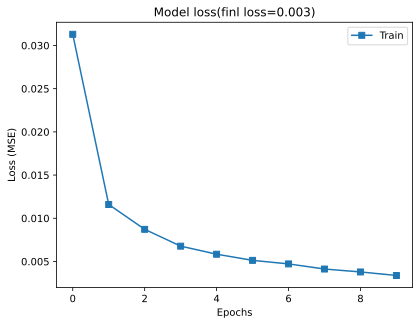

In [53]:
# Print Losses
plt.plot(losses.cpu(), "s-", label="Train")
plt.xlabel("Epochs")
plt.ylabel("Loss (MSE)")
plt.title("Model loss(finl loss=%.3f)" % losses[-1].cpu().item())
plt.legend()
plt.show()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.030504167..1.0789595].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.079805255..1.0406168].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.024153292..1.0239508].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.071086645..0.91738343].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.03864777..0.8127117].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.047574937..1.060483].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range 

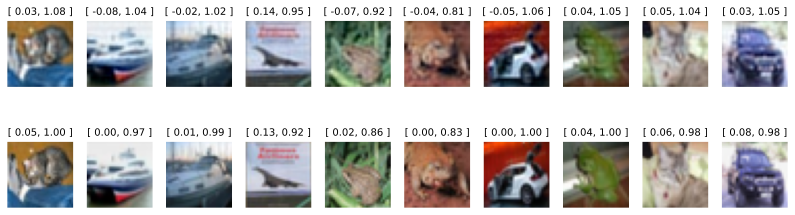

In [63]:
## show some random examples

# get some data
X, y = next(iter(test_loader))

# forward pass and loss
net.cpu()
net.eval()  # switch to test mode
yHat = net(X)


fig, axs = plt.subplots(2, 10, figsize=(14, 4))

for i in range(10):
    pic = yHat[i, :, :, :].detach().numpy().transpose((1, 2, 0))
    pic = pic / 2 + 0.5  # undo normalization
    axs[0, i].imshow(pic)
    axs[0, i].set_title(f"[ {np.min(pic):.2f}, {np.max(pic):.2f} ]", fontsize=10)
    axs[0, i].axis("off")

    pic = X[i, :, :, :].detach().numpy().transpose((1, 2, 0))
    pic = pic / 2 + 0.5  # undo normalization
    axs[1, i].imshow(pic)
    axs[1, i].set_title(f"[ {np.min(pic):.2f}, {np.max(pic):.2f} ]", fontsize=10)
    axs[1, i].axis("off")


plt.show()